Spencer Dooley<br>
STAT 287 Final Project: Determining Archetypes of Current NBA Players

In [1]:
import pandas as pd 
import numpy as np 
from bs4 import BeautifulSoup as soup 
import sklearn as sk
from sklearn.cluster import KMeans
import matplotlib as mpl 
from selenium import webdriver 
from webdriver_manager.chrome import ChromeDriverManager
import math
import seaborn as sns
from re import search
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn import svm

In [2]:
unwanted_column = "Unnamed: 0"

traditional_headers = ['PLAYER', 'TEAM', 'AGE', 'GP', 'W', 'L', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'PF', 'FP', 'DD2', 'TD3', '+/-']
traditional_stats = pd.read_csv("traditional_stats.csv")
traditional_stats = traditional_stats[:529]
del traditional_stats[unwanted_column], traditional_stats["0"]
traditional_stats.columns = traditional_headers

In [3]:
advanced_headers = ['PLAYER', 'TEAM', 'AGE', 'GP', 'W', 'L', 'MIN', 'OFFRTG', 'DEFRTG', 'NETRTG', 'AST%', 'AST/TO', 'AST\xa0Ratio', 'OREB%', 'DREB%', 'REB%', 'TORatio', 'eFG%', 'TS%', 'USG%', 'PACE', 'PIE']
advanced_stats = pd.read_csv("advanced_stats.csv")
advanced_stats = advanced_stats[:529]
del advanced_stats[unwanted_column], advanced_stats["0"]
advanced_stats.columns = advanced_headers

In [4]:
location_headers = ['Player', 'TEAM', 'AGE', '<5.FGM', '<5.FGA', '<5.FG%', '5-9.FGM', '5-9.FGA', '5-9.FG%', '10-14.FGM', '10-14.FGA', '10-14.FG%', '15-19.FGM', '15-19.FGA', '15-19.FG%',
 '20-24.FGM', '20-24.FGA', '20-24.FG%', '25-29.FGM', '25-29.FGA', '25-29.FG%']
shooting_location_stats = pd.read_csv("shooting_location_stats.csv")
shooting_location_stats = shooting_location_stats[:529]
empty_cols = [col for col in shooting_location_stats.columns if shooting_location_stats[col].isnull().all()]
del shooting_location_stats[unwanted_column]
shooting_location_stats.drop(empty_cols, axis=1, inplace=True)
shooting_location_stats.columns = location_headers

In [5]:
touches_headers = ['Player', 'Team', 'GP', 'W', 'L', 'MIN', 'PTS', 'TOUCHES', 'Front CTTouches', 'Time OfPoss', 'Avg Sec PerTouch', 'Avg Drib PerTouch', 'PTS PerTouch', 'ElbowTouches', 'PostUps', 
'PaintTouches', 'PTS PerElbow Touch', 'PTS PerPost Touch', 'PTS PerPaint Touch']
touches = pd.read_csv("touches.csv")
del touches[unwanted_column]
touches.columns = touches_headers

In [6]:
def common_columns(df1, df2):
    headers1 = df1.columns
    headers2 = df2.columns
    headers1 = set(headers1)
    headers2 = set(headers2)

    return list(headers1.intersection(headers2))
    

In [7]:
trad_adv = traditional_stats.merge(advanced_stats)
shooting_touch = shooting_location_stats.merge(touches)


In [8]:
min_req_games = math.floor(.50*max(trad_adv["GP"]))
trad_adv = trad_adv[trad_adv["GP"] > min_req_games] 
trad_adv = trad_adv[trad_adv["MIN"] > 15]

In [9]:
trad_adv.columns = trad_adv.columns.str.strip().str.lower()
shooting_touch.columns = shooting_touch.columns.str.strip().str.lower()

In [10]:
print(trad_adv["player"].duplicated().any())
print(shooting_touch["player"].duplicated().any())

False
False


In [11]:
del shooting_touch['team']


In [12]:
## merge dataframes, give suffix of z to shooting_touch common columns
all_stats = trad_adv.merge(shooting_touch, on = "player", suffixes=" z")
# remove those columns
for header in all_stats.columns:
    if search("z", header):
        del all_stats[header]
    


In [13]:
## fgm and fga are redundant/not needed
dropable_features_list = ["fga", "fgm", "pf", "fp", "pf", "dd2", "td3", "fg%", "oreb", "dreb", "ftm", "ft%", "3pm"]
dropable_features = all_stats[dropable_features_list]


In [14]:
non_feature_cols = ["player", "team", "age ", "gp ", "w ", "l ", "min "]
Y = all_stats[non_feature_cols]
X = all_stats.drop(Y, axis=1)
X = X.drop(dropable_features, axis=1)


In [15]:
# standardize data
from sklearn.preprocessing import StandardScaler
X_matrix = X.values

X_standard = StandardScaler().fit_transform(X_matrix)
X_standard = np.round(X_standard, 4)
X_standard = pd.DataFrame(X_standard)

In [16]:
from numpy import linalg as LA
cov_X = X_standard.cov()
[eigenvalues, eigenvectors] = LA.eig(cov_X)

In [17]:
eigenvalues = pd.DataFrame(data=eigenvalues, columns=['value'])
eigenvalues["variance retained"] = eigenvalues[0:]/eigenvalues[0:].sum()
eigenvalues['variance retained cumulative'] = eigenvalues['variance retained'].cumsum()

In [18]:
## I am going to branch in two different directions with 1) being using only 3 PC's for simplicity and visualizations sake and 2) using 10-15 PC's to retain a higher amount of information
# First lets do only 3 components -- all dataframes, vectors, and matrices for this version has _A at the end

feature_vec_A = eigenvectors[:, 0:3]
feature_vec_A_trasposed = feature_vec_A.transpose()
X_standard_transpose = X_standard.transpose()

final_features_A = (feature_vec_A_trasposed.dot(X_standard_transpose)).transpose()
final_features_A = pd.DataFrame(final_features_A, columns=["pc1", "pc2", "pc3"])
final_dataset_A = Y.merge(final_features_A, left_index=True, right_index=True)

In [19]:
import plotly.express as px
fig = px.scatter_3d(final_dataset_A, x='pc1', y='pc2', z='pc3',
              color='team', hover_name="player")
fig.show()

In [20]:
kmeans = KMeans(n_clusters = 10, init='k-means++', max_iter = 500, n_init=10, random_state=0)
clusters_A = kmeans.fit_predict(X = final_features_A)
clusters_A = pd.DataFrame(clusters_A, columns=["cluster"])
clusters_pcs_A = final_dataset_A.merge(clusters_A, left_index=True, right_index=True)


In [21]:
fig = px.scatter_3d(clusters_pcs_A, x='pc1', y='pc2', z='pc3',
              color='cluster', hover_name="player")
fig.show()

In [22]:
## now lets go with retaining more information and use more features to cluster the players
feature_vec = eigenvectors[:, 0:12]
feature_vec_trasposed = feature_vec.transpose()
X_standard_transpose = X_standard.transpose()

final_features = (feature_vec_trasposed.dot(X_standard_transpose)).transpose()
final_features = pd.DataFrame(final_features, columns=["pc1", "pc2", "pc3", "pc4", "pc5", "pc6", "pc7", "pc8", "pc9", "pc10", "pc11", "pc12"])



In [23]:
from sklearn.metrics import silhouette_score

for n_clusters in range(10,16):
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(final_features)
    centers = clusterer.cluster_centers_

    score = silhouette_score(final_features, preds)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 10, silhouette score is 0.13040973806365655)
For n_clusters = 11, silhouette score is 0.12950220895521838)
For n_clusters = 12, silhouette score is 0.12831943496269393)
For n_clusters = 13, silhouette score is 0.12801858966795832)
For n_clusters = 14, silhouette score is 0.11442359277156929)
For n_clusters = 15, silhouette score is 0.12084075137488953)


In [24]:
kmeans = KMeans(n_clusters = 10, init='k-means++', max_iter = 500, n_init=10, random_state=0)
clusters = kmeans.fit_predict(X = final_features)
clusters = pd.DataFrame(clusters, columns=["cluster"])
clusters_players = Y.merge(clusters, left_index=True, right_index=True)


In [25]:

# find the player closest to the centroid of the cluster - the "avg" player from the cluster  

# create dataframe of cluster centers
cluster_centers = pd.DataFrame(kmeans.cluster_centers_)


In [26]:
final_features_clusters = clusters.merge(final_features, left_index=True, right_index=True)
clusters_players["distance"] = np.nan
for player in range(0,len(final_features_clusters)):
  dist = np.linalg.norm(np.array(cluster_centers.iloc[final_features_clusters.iloc[player, 0], :]) - np.array(final_features_clusters.iloc[player, 1:13]))
  clusters_players.iloc[player, clusters_players.columns.get_loc('distance')] = dist


In [27]:
clusters_all_data = clusters_players.merge(all_stats)


In [28]:
cluster0 = clusters_all_data[clusters_all_data["cluster"]==0]
cluster1 = clusters_all_data[clusters_all_data["cluster"]==1]
cluster2 = clusters_all_data[clusters_all_data["cluster"]==2]
cluster3 = clusters_all_data[clusters_all_data["cluster"]==3]
cluster4 = clusters_all_data[clusters_all_data["cluster"]==4]
cluster5 = clusters_all_data[clusters_all_data["cluster"]==5]
cluster6 = clusters_all_data[clusters_all_data["cluster"]==6]
cluster7 = clusters_all_data[clusters_all_data["cluster"]==7]
cluster8 = clusters_all_data[clusters_all_data["cluster"]==8]
cluster9 = clusters_all_data[clusters_all_data["cluster"]==9]


In [29]:
def get_avg_player(cluster):
    cluster_df = clusters_all_data[clusters_all_data["cluster"]==cluster]
    for player in range(len(cluster_df)):
        #find player minimum distance from clusters center point
        min_index = cluster_df[['distance']].idxmin()
        player = clusters_all_data.iloc[min_index, :]
        return player



In [30]:
avg_plyr_df = pd.DataFrame()
for i in range(len(cluster_centers)):
    avg_player = get_avg_player(i)
    avg_plyr_df = avg_plyr_df.append(other = avg_player, ignore_index = True)


In [31]:
mcc_df = pd.DataFrame(clusters_all_data)
for i in range(len(cluster_centers)): 
    col_name = "cluster" + str(i)
    for j in range(len(mcc_df)):
        if mcc_df.loc[j, "cluster"] != i:
            mcc_df.loc[j, col_name] = 0
        else:
            mcc_df.loc[j, col_name] = 1
    # mcc_df[col_name] = clusters_all_data.loc[clusters_all_data['cluster'] != i, 'cluster'] = 99

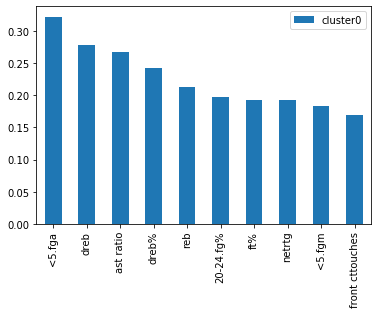

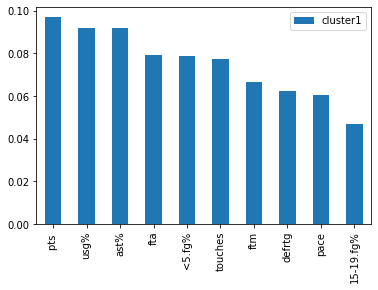

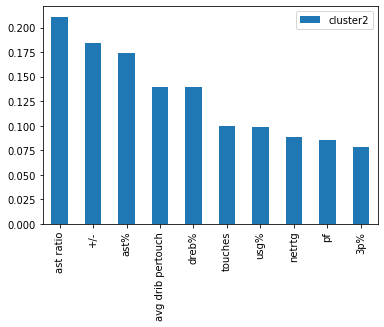

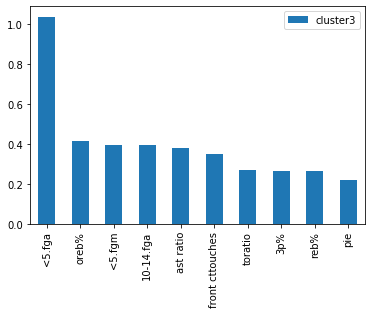

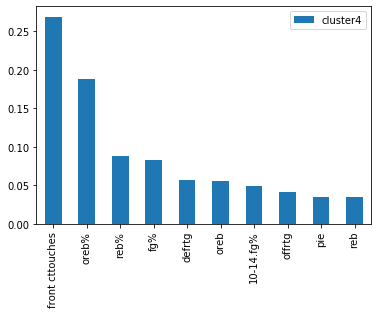

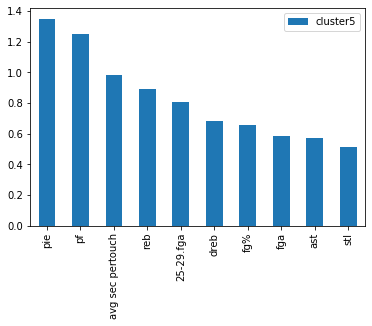

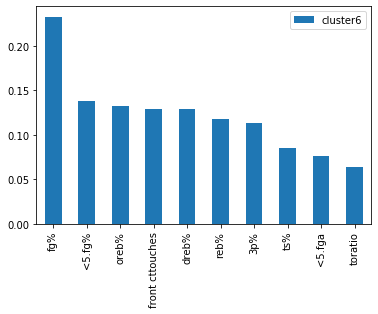

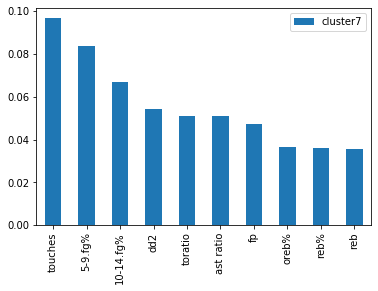

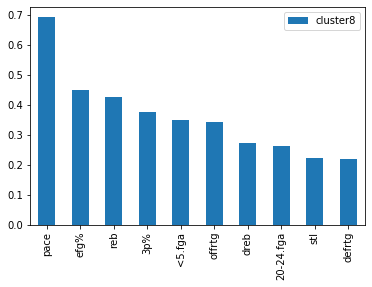

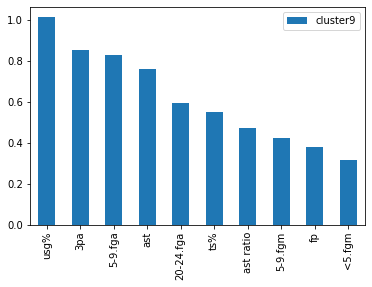

In [32]:
## trying multi class classification

coefs_df = pd.DataFrame()
accuracy_df = pd.DataFrame(columns = ['accuracy'])
accuracy_list = []
for i in range(len(cluster_centers)):
    X_train, X_test, y_train, y_test = train_test_split(mcc_df.iloc[:, 9:70], mcc_df.iloc[:, 76+i], test_size=0.2,random_state=109)
    svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train, y_train) 
    svm_predictions = svm_model_linear.predict(X_test) 
    accuracy = svm_model_linear.score(X_test, y_test)
    coefs = pd.DataFrame(svm_model_linear.coef_)
    coefs_df = coefs_df.append(coefs, ignore_index = True)
    accuracy_list.append(float(accuracy))

coefs_df.columns = (mcc_df.iloc[:, 9:70]).columns
coefs_df = coefs_df.transpose()
coefs_df.columns = (mcc_df.iloc[:, 76:]).columns


for i in range(len(cluster_centers)):
    df=coefs_df.iloc[:, i].sort_values(ascending=False).head(10).to_frame()
    df.plot(kind='bar')



In [33]:

cluster_analysis = clusters_all_data.iloc[: , 0:76].sort_values('distance', ascending=True).groupby("cluster").head(5).reset_index(drop=True).sort_values(['cluster', 'distance'], ascending = [True, True]).reset_index(drop=True)